
=== Running QBA for Arbitrary Size N=3 ===
Constraint (2N-1): 5
Selected Workspace: 3 qubits (M=8)


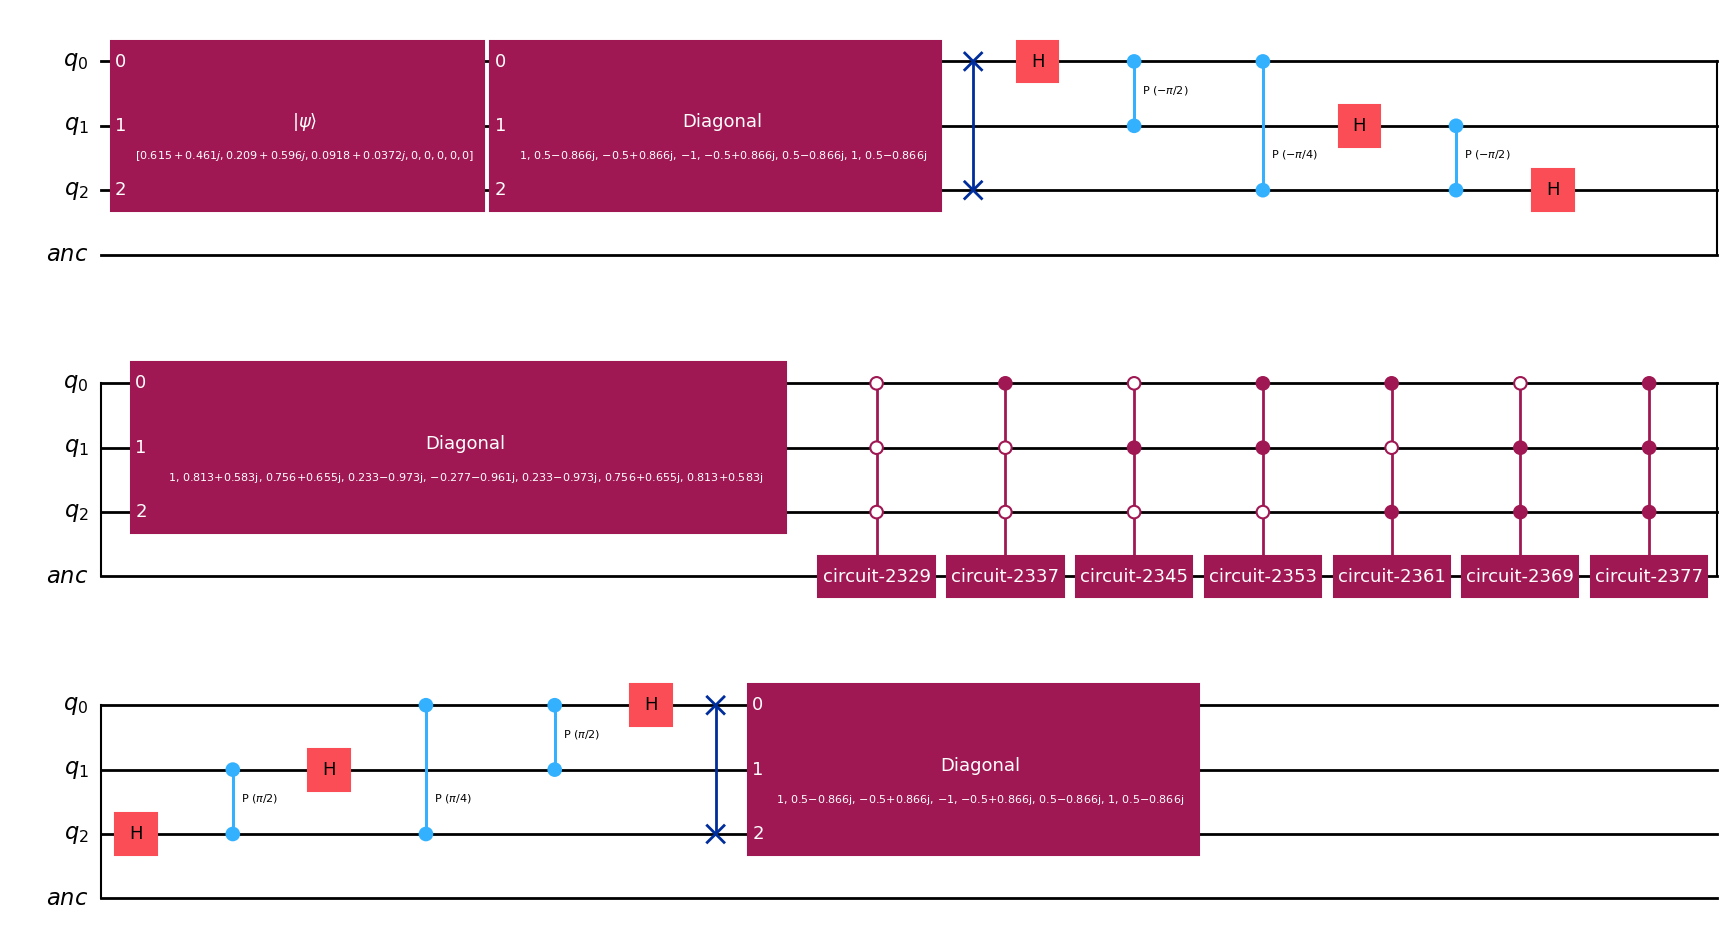

Circuit built. Simulating statevector...

--- Results ---
Target:  [ 0.529129+0.63175j   0.54767 +0.024684j -0.011044+0.142272j]
Quantum: [ 0.529129+0.63175j   0.54767 +0.024684j -0.011044+0.142272j]

Max Error: 5.41e-16
SUCCESS: True


In [3]:
# Copyright: Renata Wong (2025)
# Qiskit code, compatible with Qiskit v.2.X and later

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import DiagonalGate
from qiskit.quantum_info import Statevector

# =============================================================================
# 1. HELPER FUNCTIONS: MANUAL QFT IMPLEMENTATION
# =============================================================================
# We implement the QFT manually to ensure strict control over:
#   1. The direction of rotation (FFT vs IFFT).
#   2. The placement of SWAP gates (bit-ordering).
# This avoids ambiguity found in standard libraries regarding definitions.

def apply_fft(qc, qubits):
    """
    Implements the Forward DFT (FFT).
    Mathematical Definition: y_k = sum(x_j * e^(-2*pi*i*j*k / M))
    
    In terms of Quantum Gates, this is the INVERSE of the Standard QFT.
    Since Standard QFT (IFFT) = Swaps * Gates, 
    The Inverse QFT (FFT)     = Gates_dagger * Swaps.
    """
    n = len(qubits)
    
    # 1. SWAP Gates First
    # We swap the inputs to correctly implement the adjoint of the Standard QFT.
    for i in range(n // 2):
        qc.swap(qubits[i], qubits[n - 1 - i])
        
    # 2. Inverse QFT Layers (Hadamard + Negative Rotations)
    # We iterate forward (0 to n) matching the inverse structure.
    for i in range(n):
        qc.h(qubits[i]) # Hadamard
        for j in range(i + 1, n):
            # Controlled Phase (CP) with NEGATIVE angle for FFT behavior
            # Angle = -pi / 2^(distance)
            theta = -np.pi / (2 ** (j - i))
            qc.cp(theta, qubits[j], qubits[i])

def apply_ifft(qc, qubits):
    """
    Implements the Inverse DFT (IFFT).
    Mathematical Definition: y_k = sum(x_j * e^(+2*pi*i*j*k / M))
    
    This corresponds to the Standard QFT circuit structure:
    Standard QFT = Swaps * Gates.
    """
    n = len(qubits)
    
    # 1. Forward QFT Layers (Hadamard + Positive Rotations)
    # Standard QFT construction usually iterates in reverse for the gates.
    for i in reversed(range(n)):
        for j in reversed(range(i + 1, n)):
            # Controlled Phase (CP) with POSITIVE angle for IFFT behavior
            theta = np.pi / (2 ** (j - i))
            qc.cp(theta, qubits[j], qubits[i])
        qc.h(qubits[i]) # Hadamard
        
    # 2. SWAP Gates Last
    # Standard QFT ends with swaps to fix bit-reversal.
    for i in range(n // 2):
        qc.swap(qubits[i], qubits[n - 1 - i])

# =============================================================================
# 2. MAIN ALGORITHM: QUANTUM BLUESTEIN'S (QBA)
# =============================================================================

def run_qba(N):
    """
    Executes the Quantum Bluestein's Algorithm for an arbitrary input size N.
    """
    print(f"\n=== Running QBA for Arbitrary Size N={N} ===")

    # --- Step 1: Dynamic Workspace Sizing ---
    # To perform linear convolution of size N using FFTs (which do circular convolution),
    # we must zero-pad the space to size M >= 2N - 1.
    min_size = 2 * N - 1
    m = int(np.ceil(np.log2(min_size))) # Number of qubits
    M = 2**m                            # Hilbert space size
    
    print(f"Constraint (2N-1): {min_size}")
    print(f"Selected Workspace: {m} qubits (M={M})")

    # --- Step 2: Classical Pre-computation ---
    # We pre-calculate the diagonal phase vectors required for the algorithm.
    
    # A. Generate Random Normalized Input Vector (for demonstration)
    x_in = np.random.rand(N) + 1j * np.random.rand(N)
    x_in /= np.linalg.norm(x_in) # Must be a valid quantum state
    
    # B. Chirp Vectors (Quadratic Phases)
    # Input Chirp:  a_j = x_j * e^(-i * pi * j^2 / N)
    chirp_in = np.array([np.exp(-1j * np.pi * (j**2) / N) for j in range(M)])
    
    # Output De-chirp: X_k = y_k * e^(-i * pi * k^2 / N)
    chirp_out = np.array([np.exp(-1j * np.pi * (k**2) / N) for k in range(M)])

    # C. Convolution Kernel (Bluestein's Sequence)
    # Kernel: b_t = e^(i * pi * t^2 / N)
    # IMPORTANT: We must wrap this sequence for circular convolution[cite: 251].
    # Indices 0 to N-1 are standard. Negative indices wrap to M-1 downwards.
    b_vec = np.zeros(M, dtype=complex)
    for t in range(N):
        val = np.exp(1j * np.pi * (t**2) / N)
        b_vec[t] = val
        if t > 0: 
            b_vec[M-t] = val # Wrap b[-t] to b[M-t]

    # D. Kernel Spectrum (Frequency Domain)
    # We compute the FFT of the kernel classically. This forms the diagonal operator
    # for the convolution step [cite: 48-50].
    b_tilde = np.fft.fft(b_vec)
    
    # Normalize for Unitary Block Encoding
    # We divide by the max amplitude (alpha) to ensure all values are <= 1.
    # The "lost" probability is handled by post-selection on the ancilla.
    alpha = np.max(np.abs(b_tilde))
    normalized_b_tilde = b_tilde / alpha

    # --- Step 3: Quantum Circuit Construction ---
    qr = QuantumRegister(m, 'q')       # Workspace qubits
    anc = QuantumRegister(1, 'anc')    # Ancilla for block encoding
    qc = QuantumCircuit(qr, anc)

    # A. State Initialization
    # Embed the length-N input into the length-M zero-padded state |psi_in>.
    input_padded = np.zeros(M, dtype=complex)
    input_padded[:N] = x_in
    qc.initialize(input_padded, qr)

    # B. Input Chirp
    # Apply diagonal unitary D1: |j> -> e^(-i*pi*j^2/N) |j>
    qc.append(DiagonalGate(chirp_in), qr)

    # C. Forward FFT
    # Move to the Frequency Domain to turn Convolution into Multiplication.
    # Uses our manual function (negative exponents).
    apply_fft(qc, qr)

    # D. Convolution (Block Encoding)
    # We implement the diagonal operator U_conv = diag(b_tilde).
    # Since b_tilde is not unitary (magnitudes != 1), we use Block Encoding.
    
    # Part 1: Apply the Phases (Unitary)
    # |k> -> e^(i * arg(b_tilde_k)) |k>
    qc.append(DiagonalGate(np.exp(1j * np.angle(normalized_b_tilde))), qr)
    
    # Part 2: Apply the Magnitudes (Non-Unitary via Ancilla)
    # We perform a controlled-rotation on the ancilla such that:
    # <0| U |0> = |b_tilde_k|
    magnitudes = np.abs(normalized_b_tilde)
    # clipping makes sure that rounding errors don't lead to values that are smaller than 0 or larger than 1
    magnitudes = np.clip(magnitudes, 0.0, 1.0)
    thetas = 2 * np.arccos(magnitudes) # Angle for Ry gate
    
    for k in range(M):
        # Optimization: Only add gate if rotation is non-trivial
        if abs(thetas[k]) > 1e-10:
            c_ry = QuantumCircuit(1)
            c_ry.ry(thetas[k], 0)
            # Create a Multi-Controlled Gate that activates only for state |k>
            custom_gate = c_ry.to_gate().control(m, ctrl_state=k)
            qc.append(custom_gate, list(qr) + [anc])

    # E. Inverse FFT
    # Return to Time Domain. Uses our manual function (positive exponents).
    apply_ifft(qc, qr)

    # F. Output De-chirp
    # Apply diagonal unitary D2: |k> -> e^(-i*pi*k^2/N) |k>
    qc.append(DiagonalGate(chirp_out), qr)

    # Draw the circuit
    display(qc.draw('mpl'))

    # --- Step 4: Verification ---
    print("Circuit built. Simulating statevector...")
    state = Statevector.from_instruction(qc)
    raw_data = np.asarray(state)
    
    # Extract Result (Post-Selection)
    # We only keep the branch where the Ancilla qubit is |0>.
    # This realizes the non-unitary convolution operation.
    vector_result = np.zeros(N, dtype=complex)
    fmt = f'0{m+1}b' # Format string for bitstrings (e.g., '00101')
    
    for i in range(len(raw_data)):
        bitstr = format(i, fmt)
        # In Qiskit tensor product, Ancilla was added last, 
        # but check bitstr[0] (MSB) for safety in standard sorting.
        if bitstr[0] == '0': # Ancilla is 0
            idx = int(bitstr[1:], 2) # Remaining bits are the data index
            if idx < N:
                vector_result[idx] = raw_data[i]

    # Normalize Quantum Result (to compare with theory)
    q_norm = vector_result / np.linalg.norm(vector_result)
    
    # Calculate Classical Target (Standard FFT)
    target = np.fft.fft(x_in)
    target_norm = target / np.linalg.norm(target)

    # Robust Phase Alignment
    # Quantum states are unique up to a global phase. We rotate our result
    # to match the target's phase at the index with the largest amplitude.
    max_idx = np.argmax(np.abs(target_norm))
    if abs(target_norm[max_idx]) > 1e-9:
        diff = np.angle(target_norm[max_idx]) - np.angle(q_norm[max_idx])
        q_aligned = q_norm * np.exp(1j * diff)
    else:
        q_aligned = q_norm
        
    # Print Outcomes
    print("\n--- Results ---")
    print(f"Target:  {np.round(target_norm, 6)}")
    print(f"Quantum: {np.round(q_aligned, 6)}")
    
    max_err = np.max(np.abs(q_aligned - target_norm))
    print(f"\nMax Error: {max_err:.2e}")
    success = max_err < 1e-6
    
    return success

# =============================================================================
# 3. EXECUTION
# =============================================================================

success = run_qba(3)
print(f"SUCCESS: {success}")
